<br> Mouhammad BAZZI & Ameer Ali

Student ID : A20522180 & A20424662

CS579 - Spring 2023</br> <h1><br><b><font color='red'>Project 2</font></br></h1>

## 1. **LIBRARIES IMPORTATION**

In [1]:
# We import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Embedding, LSTM, Bidirectional, Activation, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## 2. **DATA IMPORTATION AND PREPARATION**

In [2]:
############################################
# GLOBAL VARIABLES
# We store the path of the dataset
DATA_SET_DIR = '../option1-data(1)/train.csv'
############################################

#### **DATA IMPORTATION**

In [3]:
#Importation of the dataset : train.csv

# The dataset is a csv file with 6 columns, and we will use only the last 3 columns where the last 1 is the label
# The 2 features are text where the first one is the fake news title 1 in English and the second one the news title 2 in English.
# The label indicates the relation between the news pair:  agreed/disagreed/unrelated.


#Function to load the dataset 
def load_data():
    # We load the dataset
    dataset = pd.read_csv(DATA_SET_DIR)
    # We store the features in X
    features = dataset.iloc[:, 3:5].values
    # We store the labels in y
    labels = dataset.iloc[:, 5].values
    return np.array(features), np.array(labels)

features, labels = load_data()


#### **PRE-PROCESSING THE DATASET**

In [4]:
#Preprocessing of the dataset

# We will use keras to preprocess the dataset
# We will tokenize the features using the function Tokenizer from keras
# We will use the function to_categorical from keras to convert the labels to categorical data

############################################
# GLOBAL VARIABLES
# We store the path of the dataset
VOCABULARY_SIZE = 100
############################################

# We initialize the tokenizer

tokenizer_1 = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer_2 = Tokenizer(num_words=VOCABULARY_SIZE)
# Now we process each feature separately
# We tokenize the first feature
tokenizer_1.fit_on_texts(features[:, 0])
docs_1 = tokenizer_1.texts_to_matrix(features[:, 0], mode='tfidf')
# We tokenize the second feature
tokenizer_2.fit_on_texts(features[:, 1])
docs_2 = tokenizer_2.texts_to_matrix(features[:, 1], mode='tfidf')

# We convert the labels to categorical data
def one_hot_encoding(labels):
    # We initialize the output
    labels_encoded = np.zeros((len(labels), 3))
    # We encode the labels
    for i in range(len(labels)):
        if labels[i] == 'unrelated':
            labels_encoded[i, 0] = 1
        elif labels[i] == 'agreed':
            labels_encoded[i, 1] = 1
        elif labels[i] == 'disagreed':
            labels_encoded[i, 2] = 1
    return labels_encoded

labels_encoded = one_hot_encoding(labels)

# We split the dataset into training valdiation and test set
# We will use 60% of the dataset for training, 20% for validation and 20% for testing

# We split the dataset into training and test set
docs_1_train, docs_1_test, docs_2_train, docs_2_test, labels_train, labels_test = train_test_split(docs_1, docs_2, labels_encoded, test_size=0.2, random_state=0)
# We split the training set into training and validation set
docs_1_train, docs_1_val, docs_2_train, docs_2_val, labels_train, labels_val = train_test_split(docs_1_train, docs_2_train, labels_train, test_size=0.25, random_state=0)


# We convert features to tensors
features_train = np.array([docs_1_train, docs_2_train])
features_val = np.array([docs_1_val, docs_2_val])
features_train = np.transpose(features_train, (1, 2, 0))
features_val = np.transpose(features_val, (1, 2, 0))
features_test = np.array([docs_1_test, docs_2_test])
features_test = np.transpose(features_test, (1, 2, 0))

# We output the shapes of the datasets
print('Training set shape: ', features_train.shape, labels_train.shape)
print('Validation set shape: ', features_val.shape, labels_val.shape)
print('Test set shape: ', features_test.shape, labels_test.shape)

# We reshape the features
features_train = features_train.reshape((features_train.shape[0], features_train.shape[1]*features_train.shape[2]))
features_val = features_val.reshape((features_val.shape[0], features_val.shape[1]*features_val.shape[2]))
features_test = features_test.reshape((features_test.shape[0], features_test.shape[1]*features_test.shape[2]))
print('We reshape the features: \n')

# We output the shapes of the datasets
print('Training set shape: ', features_train.shape, labels_train.shape)
print('Validation set shape: ', features_val.shape, labels_val.shape)
print('Test set shape: ', features_test.shape, labels_test.shape)

Training set shape:  (153864, 100, 2) (153864, 3)
Validation set shape:  (51289, 100, 2) (51289, 3)
Test set shape:  (51289, 100, 2) (51289, 3)
We reshape the features: 

Training set shape:  (153864, 200) (153864, 3)
Validation set shape:  (51289, 200) (51289, 3)
Test set shape:  (51289, 200) (51289, 3)


## 3. **FIRST MODEL: A SIMPLE NEURAL NETWORK**

#### **BUILDING THE MODEL**

In [5]:
def build_simple_model():
    # We initialize the model
    model = Sequential()
    # We add the layers
    model.add(Conv1D(64, 3, activation='relu', input_shape=(2*VOCABULARY_SIZE, 1)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # We compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# We build the model
model = build_simple_model()
# We print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6336)              0         
                                                                 
 dense (Dense)               (None, 64)                405568    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 406,019
Trainable params: 406,019
Non-trainable params: 0
__________________________________________________

#### **MODEL TRAINING**

Epoch 1/10
1203/1203 [==============================] - 11s 5ms/step - loss: 0.5892 - accuracy: 0.7234 - val_loss: 0.5578 - val_accuracy: 0.7412
Epoch 2/10
1203/1203 [==============================] - 5s 5ms/step - loss: 0.5413 - accuracy: 0.7490 - val_loss: 0.5374 - val_accuracy: 0.7517
Epoch 3/10
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5244 - accuracy: 0.7587 - val_loss: 0.5354 - val_accuracy: 0.7530
Epoch 4/10
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5131 - accuracy: 0.7649 - val_loss: 0.5318 - val_accuracy: 0.7554
Epoch 5/10
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5032 - accuracy: 0.7699 - val_loss: 0.5273 - val_accuracy: 0.7584
Epoch 6/10
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4942 - accuracy: 0.7744 - val_loss: 0.5280 - val_accuracy: 0.7592
Epoch 7/10
1203/1203 [==============================] - 7s 5ms/step - loss: 0.4867 - accuracy: 0.7785 - val_loss: 0.5275 - val_accuracy

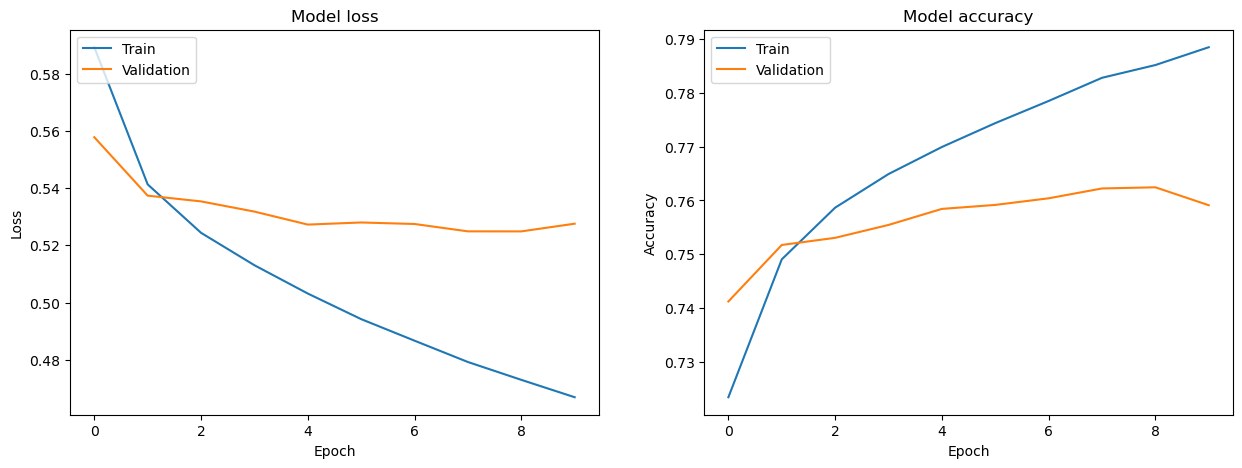

In [6]:
# We train the model

# We define the hyper-parameters
BATCH_SIZE = 128
EPOCHS = 10

# We train the model
history = model.fit(features_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(features_val, labels_val))

def plot_history(history):
    plt.figure(figsize=(15, 5))
    # We plot the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # We plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # We show the plots
    plt.show()

# We plot the history
plot_history(history)



#### **MODEL EVALUATION AND SAVING**

In [7]:
# Model evaluation

# We define the hyper-parameters
BATCH_SIZE_EVAL = 128
EPOCHS_EVAL = 2

# We train again the model with the whole training set
train_val_features = np.concatenate((features_train, features_val), axis=0)
train_val_labels = np.concatenate((labels_train, labels_val), axis=0)

model = build_simple_model()
model.fit(train_val_features, train_val_labels, batch_size=BATCH_SIZE_EVAL, epochs=EPOCHS_EVAL)

# We evaluate the model on the test set
loss, accuracy = model.evaluate(features_test, labels_test)
print('Test loss: ', loss)
print('Test accuracy: ', accuracy)

# We save the model
model.save('simple_model.h5')

Epoch 1/2
1603/1603 [==============================] - 7s 4ms/step - loss: 0.5784 - accuracy: 0.7287
Epoch 2/2
1603/1603 [==============================] - 4s 3ms/step - loss: 0.5363 - accuracy: 0.7541
Test loss:  0.5362908244132996
Test accuracy:  0.7540603280067444


## 4. **SECOND MODEL: RNN (Bidirectional LSTM)**

#### **BUILDING THE MODEL**

In [8]:
# We want to build a RNN model to classify the news pairs

# We define the model
def rnn_model():
    # We define the input layer
    inputs = Input(shape=(2*VOCABULARY_SIZE,))

    # Define the embedding layer
    embedding = Embedding(2*VOCABULARY_SIZE, 32)(inputs)
    # Define the bidirectional LSTM layer
    lstm = Bidirectional(LSTM(64))(embedding)
    dense_1 = Dense(32, activation="relu")(lstm)
    output = Dense(3, activation="softmax")(dense_1)
    model = Model(inputs=inputs, outputs=output)

    # We compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# We build the model
model = rnn_model()
# We print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 32)           6400      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 60,291
Trainable params: 60,291
Non-trainable params: 0
_________________________________________________________

#### **MODEL TRAINING**

Epoch 1/10
1203/1203 [==============================] - 62s 49ms/step - loss: 0.7141 - accuracy: 0.6839 - val_loss: 0.7052 - val_accuracy: 0.6867
Epoch 2/10
1203/1203 [==============================] - 59s 49ms/step - loss: 0.6973 - accuracy: 0.6864 - val_loss: 0.6904 - val_accuracy: 0.6869
Epoch 3/10
1203/1203 [==============================] - 60s 50ms/step - loss: 0.6841 - accuracy: 0.6910 - val_loss: 0.6766 - val_accuracy: 0.6932
Epoch 4/10
1203/1203 [==============================] - 63s 52ms/step - loss: 0.6766 - accuracy: 0.6968 - val_loss: 0.6707 - val_accuracy: 0.6997
Epoch 5/10
1203/1203 [==============================] - 58s 48ms/step - loss: 0.6722 - accuracy: 0.7001 - val_loss: 0.6682 - val_accuracy: 0.7020
Epoch 6/10
1203/1203 [==============================] - 60s 50ms/step - loss: 0.6684 - accuracy: 0.7022 - val_loss: 0.6642 - val_accuracy: 0.7047
Epoch 7/10
1203/1203 [==============================] - 60s 50ms/step - loss: 0.6648 - accuracy: 0.7040 - val_loss: 0.6648 -

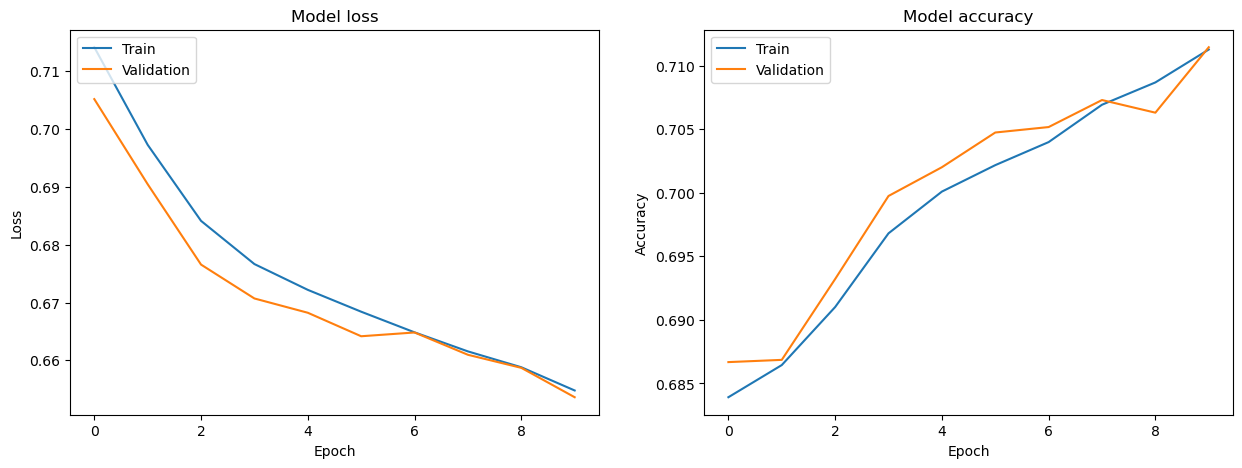

In [9]:
# We set the hyper-parameters
BATCH_SIZE = 128
EPOCHS = 10

# Training of the model
history = model.fit(features_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(features_val, labels_val))

#We plot the training and validation accuracy and loss
plot_history(history)

In [11]:
# We evaluate the model on the test set
loss, accuracy = model.evaluate(features_test, labels_test)

print('Test loss: ', loss)
print('Test accuracy: ', accuracy)

1603/1603 [==============================] - 28s 18ms/step - loss: 0.6612 - accuracy: 0.7118
Test loss:  0.6612340807914734
Test accuracy:  0.7117900252342224


#### **MODEL EVALUATION AND SAVING**

In [12]:
# We train again the model with the whole training set

# We set the hyper-parameters
BATCH_SIZE_EVAL = 128
EPOCHS_EVAL = 10

train_val_features = np.concatenate((features_train, features_val), axis=0)
train_val_labels = np.concatenate((labels_train, labels_val), axis=0)

model = rnn_model()
model.fit(train_val_features, train_val_labels, batch_size=BATCH_SIZE_EVAL, epochs=EPOCHS_EVAL)

# We evaluate the model on the test set
loss, accuracy = model.evaluate(features_test, labels_test)

print('Test loss: ', loss)
print('Test accuracy: ', accuracy)

# We save the model
model.save('rnn_model.h5')

Epoch 1/10
1603/1603 [==============================] - 85s 52ms/step - loss: 0.7126 - accuracy: 0.6850
Epoch 2/10
1603/1603 [==============================] - 84s 52ms/step - loss: 0.6930 - accuracy: 0.6874
Epoch 3/10
1603/1603 [==============================] - 84s 52ms/step - loss: 0.6797 - accuracy: 0.6935
Epoch 4/10
1603/1603 [==============================] - 86s 53ms/step - loss: 0.6724 - accuracy: 0.6987
Epoch 5/10
1603/1603 [==============================] - 95s 59ms/step - loss: 0.6676 - accuracy: 0.7034
Epoch 6/10
1603/1603 [==============================] - 92s 57ms/step - loss: 0.6638 - accuracy: 0.7058
Epoch 7/10
1603/1603 [==============================] - 91s 57ms/step - loss: 0.6591 - accuracy: 0.7087
Epoch 8/10
1603/1603 [==============================] - 91s 57ms/step - loss: 0.6537 - accuracy: 0.7126
Epoch 9/10
1603/1603 [==============================] - 91s 57ms/step - loss: 0.6505 - accuracy: 0.7137
Epoch 10/10
1603/1603 [==============================] - 30s 18m

## 5. **THIRD MODEL: More Complex Neural Network**

#### **BUILDING THE MODEL**

In [13]:
# We will build a simple ANN model to classify the news pairs

# We import the libraries


def build_complex_model():
    # We initialize the model
    model = Sequential()
    # We flatten the input
    model.add(Flatten(input_shape=(2*VOCABULARY_SIZE,)))
    # We add the layers
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    model.add(Dense(3, activation='softmax'))

    # We compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# We build the model
model = build_complex_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               51456     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 activation_1 (Activation)   (None, 128)              

#### **MODEL TRAINING**

Epoch 1/25
1203/1203 [==============================] - 11s 8ms/step - loss: 0.7327 - accuracy: 0.6786 - val_loss: 0.6240 - val_accuracy: 0.6867
Epoch 2/25
1203/1203 [==============================] - 12s 10ms/step - loss: 0.6350 - accuracy: 0.6879 - val_loss: 0.5993 - val_accuracy: 0.7063
Epoch 3/25
1203/1203 [==============================] - 11s 9ms/step - loss: 0.6035 - accuracy: 0.7054 - val_loss: 0.5699 - val_accuracy: 0.7175
Epoch 4/25
1203/1203 [==============================] - 11s 9ms/step - loss: 0.5771 - accuracy: 0.7263 - val_loss: 0.5472 - val_accuracy: 0.7481
Epoch 5/25
1203/1203 [==============================] - 10s 8ms/step - loss: 0.5597 - accuracy: 0.7404 - val_loss: 0.5420 - val_accuracy: 0.7494
Epoch 6/25
1203/1203 [==============================] - 11s 9ms/step - loss: 0.5483 - accuracy: 0.7505 - val_loss: 0.5320 - val_accuracy: 0.7629
Epoch 7/25
1203/1203 [==============================] - 11s 9ms/step - loss: 0.5384 - accuracy: 0.7571 - val_loss: 0.5223 - val_a

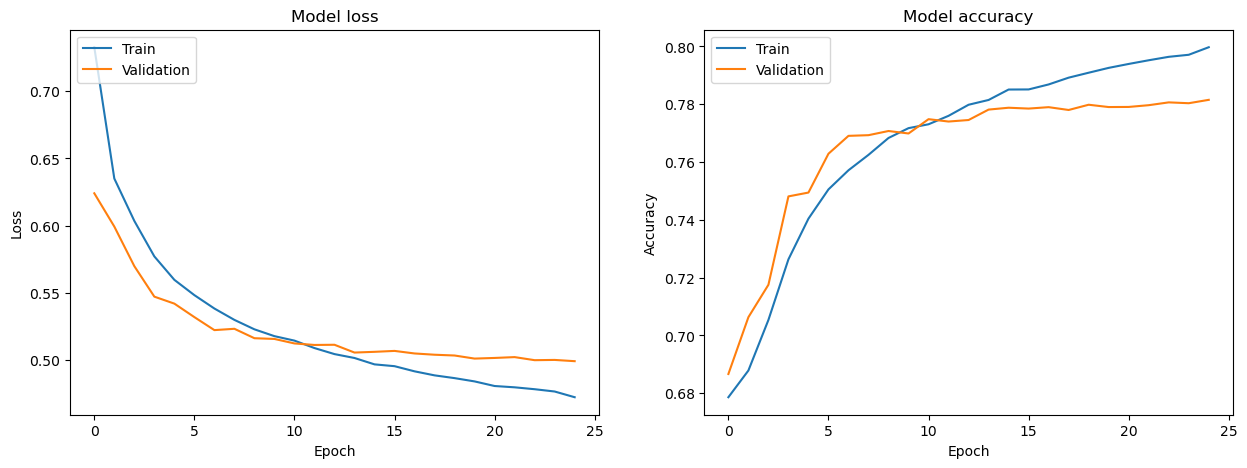

In [14]:
#Training of the model

#We set the hyper-parameters
BATCH_SIZE = 128
EPOCHS = 25

#We train the model
history = model.fit(features_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(features_val, labels_val))

#We plot the training and validation accuracy and loss
plot_history(history)


#### **MODEL EVALUATION AND SAVING**

In [15]:
# Model evaluation

# We set the hyper-parameters
BATCH_SIZE_EVAL = 128
EPOCHS_EVAL = 9

# We train again the model with the whole training set
train_val_features = np.concatenate((features_train, features_val), axis=0)
train_val_labels = np.concatenate((labels_train, labels_val), axis=0)

model = build_complex_model()
model.fit(train_val_features, train_val_labels, batch_size=BATCH_SIZE_EVAL, epochs=EPOCHS_EVAL)

# We evaluate the model on the test set
loss, accuracy = model.evaluate(features_test, labels_test)
print('Test loss: ', loss)
print('Test accuracy: ', accuracy)

# We save the model
model.save('complex_model.h5')

Epoch 1/9
1603/1603 [==============================] - 12s 7ms/step - loss: 0.7034 - accuracy: 0.6781
Epoch 2/9
1603/1603 [==============================] - 12s 8ms/step - loss: 0.6156 - accuracy: 0.6974
Epoch 3/9
1603/1603 [==============================] - 12s 8ms/step - loss: 0.5787 - accuracy: 0.7268
Epoch 4/9
1603/1603 [==============================] - 13s 8ms/step - loss: 0.5578 - accuracy: 0.7423
Epoch 5/9
1603/1603 [==============================] - 13s 8ms/step - loss: 0.5459 - accuracy: 0.7511
Epoch 6/9
1603/1603 [==============================] - 13s 8ms/step - loss: 0.5371 - accuracy: 0.7592
Epoch 7/9
1603/1603 [==============================] - 14s 9ms/step - loss: 0.5285 - accuracy: 0.7644
Epoch 8/9
1603/1603 [==============================] - 14s 9ms/step - loss: 0.5211 - accuracy: 0.7691
Epoch 9/9
1603/1603 [==============================] - 9s 5ms/step - loss: 0.5130 - accuracy: 0.7731
Test loss:  0.5129877328872681
Test accuracy:  0.7731092572212219


## 6. Transformer

In [16]:
def transformer_block(inputs, num_heads, dim, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=dim)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attn_output]))

    ffn_output = Dense(dim, activation="relu")(out1)
    ffn_output = Dense(dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ffn_output]))

def build_transformer_model(vocab_size, num_heads, dim, num_layers, dropout_rate):
    inputs = Input(shape=(2 * vocab_size,))
    x = Dense(dim, activation="relu")(inputs)
    x = Reshape((1, dim))(x)  # Add a temporal dimension
    
    for _ in range(num_layers):
        x = transformer_block(x, num_heads, dim, dropout_rate)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(3, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

num_heads = 4
dim = 64
num_layers = 2
dropout_rate = 0.1

transformer_model = build_transformer_model(VOCABULARY_SIZE, num_heads, dim, num_layers, dropout_rate)

transformer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 64)           12864       ['input_3[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 64)        0           ['dense_18[0][0]']               
                                                                                                  
 multi_head_attention (MultiHea  (None, 1, 64)       66368       ['reshape[0][0]',                
 dAttention)                                                      'reshape[0][0]']          

Epoch 1/8
1203/1203 [==============================] - 41s 33ms/step - loss: 0.6133 - accuracy: 0.7016 - val_loss: 0.5754 - val_accuracy: 0.7221
Epoch 2/8
1203/1203 [==============================] - 37s 30ms/step - loss: 0.5459 - accuracy: 0.7460 - val_loss: 0.5392 - val_accuracy: 0.7495
Epoch 3/8
1203/1203 [==============================] - 33s 28ms/step - loss: 0.5205 - accuracy: 0.7609 - val_loss: 0.5321 - val_accuracy: 0.7545
Epoch 4/8
1203/1203 [==============================] - 28s 24ms/step - loss: 0.5056 - accuracy: 0.7709 - val_loss: 0.5277 - val_accuracy: 0.7572
Epoch 5/8
1203/1203 [==============================] - 28s 23ms/step - loss: 0.4939 - accuracy: 0.7775 - val_loss: 0.5335 - val_accuracy: 0.7599
Epoch 6/8
1203/1203 [==============================] - 34s 28ms/step - loss: 0.4853 - accuracy: 0.7817 - val_loss: 0.5251 - val_accuracy: 0.7596
Epoch 7/8
1203/1203 [==============================] - 37s 31ms/step - loss: 0.4778 - accuracy: 0.7860 - val_loss: 0.5261 - val_ac

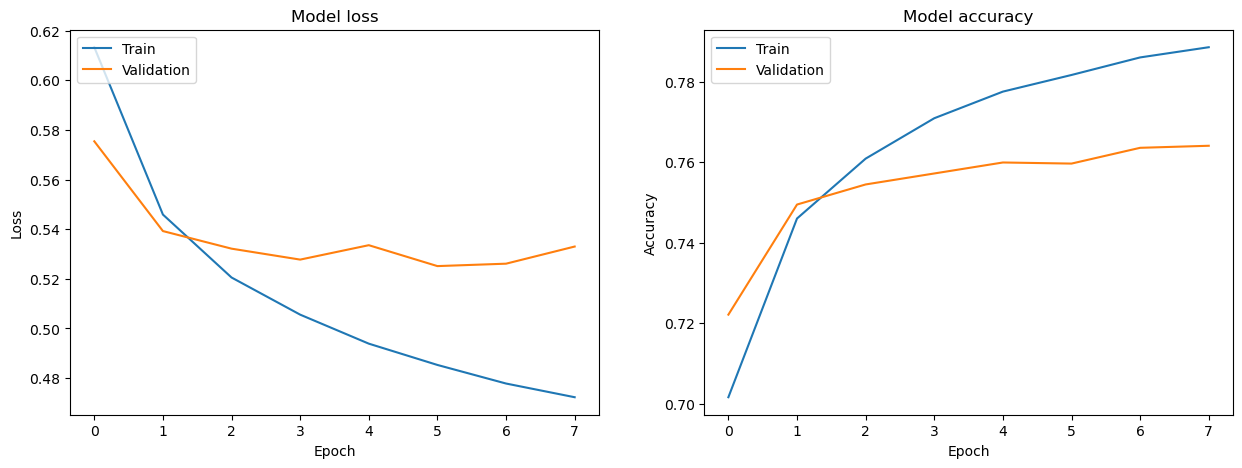

In [17]:
#Training of the model

#We set the hyper-parameters
BATCH_SIZE = 128
EPOCHS = 8

#We train the model
history = transformer_model.fit(features_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(features_val, labels_val))

#We plot the training and validation accuracy and loss
plot_history(history)

In [18]:
# Model evaluation

# We set the hyper-parameters
BATCH_SIZE_EVAL = 128
EPOCHS_EVAL = 1

# We train again the model with the whole training set
train_val_features = np.concatenate((features_train, features_val), axis=0)
train_val_labels = np.concatenate((labels_train, labels_val), axis=0)

transformer_model = build_transformer_model(VOCABULARY_SIZE, num_heads, dim, num_layers, dropout_rate)
transformer_model.fit(train_val_features, train_val_labels, batch_size=BATCH_SIZE_EVAL, epochs=EPOCHS_EVAL)

# We evaluate the model on the test set
loss, accuracy = transformer_model.evaluate(features_test, labels_test)
print('Test loss: ', loss)
print('Test accuracy: ', accuracy)

# We save the model
transformer_model.save('transformer_model.h5')

1603/1603 [==============================] - 22s 13ms/step - loss: 0.5602 - accuracy: 0.7398
Test loss:  0.5601567625999451
Test accuracy:  0.7397687435150146


## 6. **ENSEMBLE CLASSIFIER**

In [19]:
# We will create an ensemble classifier using the three models we have built

# We load the models
simple_model = load_model('simple_model.h5')
rnn_model = load_model('rnn_model.h5')
complex_model = load_model('complex_model.h5')
transformer_model = load_model('transformer_model.h5')

# We define the function to predict the labels
def predict_labels(model, data):
    # We predict the labels
    predictions = model.predict(data)
    # We get the labels
    labels = np.argmax(predictions, axis=1)
    return labels

# We define the function to evaluate the model
def evaluate_model(model, data, labels):
    # We predict the labels
    predictions = predict_labels(model, data)
    # We compute the accuracy
    loss, accuracy = model.evaluate(data, labels)
    # We print the results
    print('Accuracy: ', accuracy)
    print('Confusion matrix: ')
    print(confusion_matrix(np.argmax(labels, axis=1), predictions))
    print('Classification report: ')
    print(classification_report(np.argmax(labels, axis=1), predictions))

# We evaluate the simple model
print('Simple model')
evaluate_model(simple_model, features_test, labels_test)

# We evaluate the RNN model
print('RNN model')
evaluate_model(rnn_model, features_test, labels_test)

# We evaluate the complex model
print('Complex model')
evaluate_model(complex_model, features_test, labels_test)

# We evaluate the transformer model
print('Transformer model')
evaluate_model(transformer_model, features_test, labels_test)


Simple model
1603/1603 [==============================] - 8s 5ms/step - loss: 0.5363 - accuracy: 0.7541
Accuracy:  0.7540603280067444
Confusion matrix: 
[[31716  3345     9]
 [ 7916  6902     1]
 [ 1222   121    57]]
Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.90      0.84     35070
           1       0.67      0.47      0.55     14819
           2       0.85      0.04      0.08      1400

    accuracy                           0.75     51289
   macro avg       0.76      0.47      0.49     51289
weighted avg       0.75      0.75      0.73     51289

RNN model
1603/1603 [==============================] - 36s 22ms/step - loss: 0.6511 - accuracy: 0.7149
Accuracy:  0.7148706316947937
Confusion matrix: 
[[32923  2147     0]
 [11077  3742     0]
 [ 1280   120     0]]
Classification report: 
              precision    recall  f1-score   support

           0       0.73      0.94      0.82     35070
           1       0.62      

c:\Users\Ameer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ameer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ameer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1603/1603 [==============================] - 8s 5ms/step - loss: 0.5130 - accuracy: 0.7731
Accuracy:  0.7731092572212219
Confusion matrix: 
[[32718  2352     0]
 [ 7936  6883     0]
 [ 1298    51    51]]
Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     35070
           1       0.74      0.46      0.57     14819
           2       1.00      0.04      0.07      1400

    accuracy                           0.77     51289
   macro avg       0.84      0.48      0.50     51289
weighted avg       0.77      0.77      0.75     51289

Transformer model
1603/1603 [==============================] - 19s 12ms/step - loss: 0.5602 - accuracy: 0.7398
Accuracy:  0.7397687435150146
Confusion matrix: 
[[30753  4311     6]
 [ 7686  7129     4]
 [ 1264    76    60]]
Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.88      0.82     35070
           1       0.62      0.48 

In [20]:
# We define the function to predict the labels
def predict_labels_ensemble(models, data):
    # We predict the labels
    predictions = np.zeros((data.shape[0], 3))
    for model in models:
        predictions += model.predict(data)
    # We get the labels
    labels = np.argmax(predictions, axis=1)
    return labels

# We define the function to evaluate the model
def evaluate_model_ensemble(models, data, labels):
    # We predict the labels
    predictions = predict_labels_ensemble(models, data)
    # We compute the accuracy
    accuracy = accuracy_score(np.argmax(labels, axis=1), predictions)
    # We print the results
    print('Accuracy: ', accuracy)
    print('Confusion matrix: ')
    print(confusion_matrix(np.argmax(labels, axis=1), predictions))
    print('Classification report: ')
    print(classification_report(np.argmax(labels, axis=1), predictions))

# We evaluate the ensemble model
print('Ensemble model')
evaluate_model_ensemble([simple_model, rnn_model, complex_model, transformer_model], features_test, labels_test)

Ensemble model
1603/1603 [==============================] - 17s 11ms/step
Accuracy:  0.7641794536840258
Confusion matrix: 
[[33096  1974     0]
 [ 8775  6044     0]
 [ 1296    50    54]]
Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.94      0.85     35070
           1       0.75      0.41      0.53     14819
           2       1.00      0.04      0.07      1400

    accuracy                           0.76     51289
   macro avg       0.84      0.46      0.48     51289
weighted avg       0.77      0.76      0.73     51289

